# Bike

In [1]:
import numpy as np
from numpy import sin,cos,pi,sqrt
np.set_printoptions(precision=7,suppress=True)
from numpy.linalg import inv
import matplotlib.pyplot as plt
import control as ct

In [7]:
class Bike():
    angle=0.1/180*pi
    g=9.81
    def __init__(self,w=1.02,c=0.08,lmd=pi/10,rR=0.3,mR=2,IRxx=0.0603,IRyy=0.12,xB=0.3,zB=-0.9,mB=85,IBxx=9.2,IBxz=2.4,IBzz=2.8,IByy=11,
                 xH=0.9,zH=-0.7,mH=4,IHxx=0.05892,IHxz=-0.00756,IHzz=0.00708,IHyy=0.06,rF=0.35,mF=3,IFxx=0.1405,IFyy=0.28):
        self.w=w
        self.c=c
        self.lmd=lmd
        self.rR=rR
        self.mR=mR
        self.IRxx=IRxx
        self.IRyy=IRyy
        self.IRzz=IRxx
        self.xB=xB
        self.zB=zB
        self.mB=mB
        self.IBxx=IBxx
        self.IBxz=IBxz
        self.IBzz=IBzz
        self.IByy=IByy
        self.xH=xH
        self.zH=zH
        self.mH=mH
        self.IHxx=IHxx
        self.IHxz=IHxz
        self.IHzz=IHzz
        self.IHyy=IHyy
        self.rF=rF
        self.mF=mF
        self.IFxx=IFxx
        self.IFyy=IFyy
        self.IFzz=IFxx
        self.mu=c/w*cos(lmd)
    # region linear model coefficient
    def K0(self):
        SA=-(self.mH*self.zH-self.mF*self.rF)*sin(self.lmd)+(self.mH*(self.xH-self.w-self.c)-self.mF*self.c)*cos(self.lmd)+self.c/self.w*cos(self.lmd)*(self.mB*self.xB+self.mH*self.xH+self.mF*self.w)
        K0=np.array([
            [-self.mR*self.rR+self.mB*self.zB+self.mH*self.zH-self.mF*self.rF,-SA],
            [-SA,-SA*sin(self.lmd)]
        ])
        return K0
    def M(self):
        muxSH=self.mu*self.xH+(cos(self.lmd)*(self.xH-self.w-self.c)-sin(self.lmd)*self.zH)
        muxSF=self.mu*self.w+(-cos(self.lmd)*self.c+sin(self.lmd)*self.rF)
        R_T=self.mR*np.array([
            [self.rR**2,0],
            [0,0]
        ]) 
        B_T=self.mB*np.array([
            [self.zB**2,-self.mu*self.xB*self.zB],
            [-self.mu*self.xB*self.zB,self.mu**2*self.xB**2]
        ])
        H_T=self.mH*np.array([
            [self.zH**2,-muxSH*self.zH],
            [-muxSH*self.zH,muxSH**2]
        ])
        F_T=self.mF*np.array([
            [self.rF**2,muxSF*self.rF],
            [muxSF*self.rF,muxSF**2]
        ])
        R_R=np.array([
            [self.IRxx,0],
            [0,self.mu**2*self.IRxx]
        ])
        B_R=np.array([
            [self.IBxx,self.mu*self.IBxz],
            [self.mu*self.IBxz,self.mu**2*self.IBzz]
        ])
        H_R=np.array([
            [self.IHxx,sin(self.lmd)*self.IHxx+(self.mu+cos(self.lmd))*self.IHxz],
            [sin(self.lmd)*self.IHxx+(self.mu+cos(self.lmd))*self.IHxz,(self.mu+cos(self.lmd))**2*self.IHzz+2*sin(self.lmd)*(self.mu+cos(self.lmd))*self.IHxz+sin(self.lmd)**2*self.IHxx]
        ])
        F_R=np.array([
            [self.IFxx,self.IFxx*sin(self.lmd)],
            [self.IFxx*sin(self.lmd),self.IFxx*((self.mu+cos(self.lmd))**2+sin(self.lmd)**2)]
        ])
        return R_T+B_T+H_T+F_T+R_R+B_R+H_R+F_R
    def C1(self):
        cH=(self.mu*self.xH+cos(self.lmd)*(self.xH-self.w-self.c)-sin(self.lmd)*self.zH)*(self.mu+cos(self.lmd)/self.w*self.xH)
        cF=(self.mu*self.w-cos(self.lmd)*self.c+sin(self.lmd)*self.rF)*(self.mu+cos(self.lmd))
        R_T=self.mR*np.array([
            [0,self.mu*self.rR],
            [0,0]
        ]) 
        B_T=self.mB*np.array([
            [0,-self.zB*(self.mu+cos(self.lmd)/self.w*self.xB)],
            [0,self.mu*self.xB*(self.mu+cos(self.lmd)/self.w*self.xB)]
        ])
        H_T=self.mH*np.array([
            [0,-self.zH*(self.mu+cos(self.lmd)/self.w*self.xH)],
            [0,cH]
        ])
        F_T=self.mF*np.array([
            [0,self.rF*(self.mu+cos(self.lmd))],
            [0,cF]
        ])
        R_R=np.array([
            [0,self.mu/self.rR*self.IRyy],
            [-self.mu/self.rR*self.IRyy,self.mu*cos(self.lmd)/self.w*self.IRxx]
        ])
        B_R=np.array([
            [0,cos(self.lmd)/self.w*self.IBxz],
            [0,self.mu*cos(self.lmd)/self.w*self.IBzz]
        ])
        H_R=np.array([
            [0,cos(self.lmd)/self.w*self.IHxz],
            [0,cos(self.lmd)/self.w*(sin(self.lmd)*self.IHxz+(self.mu+cos(self.lmd))*self.IHzz)]
        ])
        F_R=np.array([
            [0,(self.mu+cos(self.lmd))/self.rF*self.IFyy],
            [-(self.mu+cos(self.lmd))/self.rF*self.IFyy,cos(self.lmd)*(self.mu+cos(self.lmd))/self.w*self.IFxx]
        ])
        return R_T+B_T+H_T+F_T+R_R+B_R+H_R+F_R
    def K2(self):
        bH=cos(self.lmd)/self.w*(self.mu*self.xH+cos(self.lmd)*(self.xH-self.w-self.c)-sin(self.lmd)*self.zH)
        bF=cos(self.lmd)/self.w*(self.mu*self.w-cos(self.lmd)*self.c+sin(self.lmd)*self.rF)
        R_T=self.mR*np.array([
            [0,cos(self.lmd)/self.w*self.rR],
            [0,0]
        ])
        B_T=self.mB*np.array([
            [0,-cos(self.lmd)/self.w*self.zB],
            [0,cos(self.lmd)/self.w*self.mu*self.xB]
        ])
        H_T=self.mH*np.array([
            [0,-cos(self.lmd)/self.w*self.zH],
            [0,bH]
        ]) 
        F_T=self.mF*np.array([
            [0,cos(self.lmd)/self.w*self.rF],
            [0,bF]
        ]) 
        R_R=np.array([
            [0,1/self.rR*cos(self.lmd)/self.w*self.IRyy],
            [0,0]
        ]) 
        B_R=np.array([
            [0,0],
            [0,0]
        ]) 
        H_R=np.array([
            [0,0],
            [0,0]
        ]) 
        F_R=np.array([
            [0,1/self.rF*self.IFyy/self.w*cos(self.lmd)],
            [0,sin(self.lmd)/self.rF*cos(self.lmd)/self.w*self.IFyy]
        ])
        return R_T+B_T+H_T+F_T+R_R+B_R+H_R+F_R
    def Lit(self):
        mT=self.mR+self.mB+self.mH+self.mF
        if mT==0:
            xT=0
            zT=0
        else:
            xT=(self.mB*self.xB+self.mH*self.xH+self.mF*self.w)/mT
            zT=(-self.mR*self.rR+self.mB*self.zB+self.mH*self.zH-self.mF*self.rF)/mT
        mA=self.mH+self.mF
        if mA==0:
            xA=0
            zA=0
        else:
            xA=(self.mH*self.xH+self.mF*self.w)/mA
            zA=(self.mH*self.zH-self.mF*self.rF)/mA
        uA=(xA-self.w-self.c)*cos(self.lmd)-zA*sin(self.lmd)
        SA=mA*uA+self.mu*mT*xT
        SR=self.IRyy/self.rR
        SF=self.IFyy/self.rF
        ST=SR+SF
        ITxx=self.mR*self.rR**2+self.mB*self.zB**2+self.mH*self.zH**2+self.mF*self.rF**2+self.IRxx+self.IBxx+self.IHxx+self.IFxx
        ITzz=self.mB*self.xB**2+self.mH*self.xH**2+self.mF*self.w**2+self.IRzz+self.IBzz+self.IHzz+self.IFzz
        ITxz=-self.mB*self.xB*self.zB-self.mH*self.xH*self.zH+self.mF*self.rF*self.w+self.IBxz+self.IHxz
        IAxx=self.mH*(self.zH-zA)**2+self.mF*(self.rF+zA)**2+self.IHxx+self.IFxx
        IAzz=self.mH*(self.xH-xA)**2+self.mF*(self.w-xA)**2+self.IHzz+self.IFzz
        IAxz=-self.mH*(self.xH-xA)*(self.zH-zA)+self.mF*(self.w-xA)*(self.rF+zA)+self.IHxz
        IAll=mA*uA**2+IAxx*sin(self.lmd)**2+2*IAxz*sin(self.lmd)*cos(self.lmd)+IAzz*cos(self.lmd)**2
        IAlx=-mA*uA*zA+IAxx*sin(self.lmd)+IAxz*cos(self.lmd)
        IAlz=mA*uA*xA+IAxz*sin(self.lmd)+IAzz*cos(self.lmd)
        K0=np.array([
            [mT*zT,-SA],
            [-SA,-SA*sin(self.lmd)]
        ])
        K2=cos(self.lmd)/self.w*np.array([
            [0,ST-mT*zT],
            [0,SA+SF*sin(self.lmd)]
        ])
        C1=np.array([
            [0,self.mu*ST+SF*cos(self.lmd)+cos(self.lmd)/self.w*ITxz-self.mu*mT*zT],
            [-self.mu*ST-SF*cos(self.lmd),cos(self.lmd)/self.w*IAlz+self.mu*SA+self.mu*cos(self.lmd)/self.w*ITzz]
        ])
        M=np.array([
            [ITxx,IAlx+self.mu*ITxz],
            [IAlx+self.mu*ITxz,IAll+2*self.mu*IAlz+self.mu**2*ITzz]
        ])
        return M,K0,K2,C1
    def LinearMatrix(self,v):
        A=np.vstack((np.hstack((np.zeros((2,2)),np.identity(2))),np.hstack((-inv(self.M())@(self.g*self.K0()+v*v*self.K2()),-inv(self.M())@self.C1()*v))))
        B=np.vstack((np.zeros((2,1)),inv(self.M())@np.array([[0],[1]])))
        return A,B
    # endregion
    # region find thetaB and thetaU
    def Zero(self,phi,thetaB,delta,thetaU):
        Zero=(
        -self.rR*cos(phi)-self.c*cos(self.lmd)*sin(phi)*sin(delta)+self.rR*cos(phi)*cos(thetaB)
        -(self.w+self.c)*cos(phi)*sin(thetaB)+self.rF*cos(self.lmd)*sin(phi)*sin(delta)*sin(thetaU)
        +self.rF*sin(self.lmd)*sin(phi)*sin(delta)-self.rF*sin(self.lmd)*sin(phi)*sin(delta)*cos(thetaU)
        -2*self.rF*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2*sin(thetaB)*sin(thetaU)-2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        +2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)+2*self.rF*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2*cos(thetaB)*cos(thetaU)
        -cos(phi)*(-self.c*cos(delta)-2*self.c*sin(self.lmd)**2*sin(delta/2)**2-2*self.rF*sin(self.lmd)*cos(self.lmd)*sin(delta/2)**2)*sin(thetaB)
        +cos(phi)*(-self.rF*cos(delta)-2*self.c*sin(self.lmd)*cos(self.lmd)*sin(delta/2)**2-2*self.rF*cos(self.lmd)**2*sin(delta/2)**2)*cos(thetaB)
        +self.rF*cos(phi)*cos(delta)*cos(thetaB)*cos(thetaU)-self.rF*cos(phi)*cos(delta)*sin(thetaB)*sin(thetaU)
        )
        return Zero
    def Low(self,phi,thetaB,delta,thetaU):
        Low=(
        cos(self.lmd)*sin(phi)*sin(delta)*cos(thetaU)+sin(self.lmd)*sin(phi)*sin(delta)*sin(thetaU)
        -(cos(phi)*cos(delta)+2*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2)*cos(thetaB)*sin(thetaU)
        -(cos(phi)*cos(delta)+2*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2)*sin(thetaB)*cos(thetaU)
        +2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*cos(thetaU)
        +2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*sin(thetaU)
        )
        return Low
    def dZerodthetaB(self,phi,thetaB,delta,thetaU):
        dZerodthetaB=(
        -self.rR*cos(phi)*sin(thetaB)-(self.w+self.c)*cos(phi)*cos(thetaB)
        -2*self.rF*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)
        -2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*cos(thetaU)
        -2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*sin(thetaU)
        -2*self.rF*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        -cos(phi)*(-self.c*cos(delta)-2*self.c*sin(self.lmd)**2*sin(delta/2)**2-2*self.rF*sin(self.lmd)*cos(self.lmd)*sin(delta/2)**2)*cos(thetaB)
        -cos(phi)*(-self.rF*cos(delta)-2*self.c*sin(self.lmd)*cos(self.lmd)*sin(delta/2)**2-2*self.rF*cos(self.lmd)**2*sin(delta/2)**2)*sin(thetaB)
        -self.rF*cos(phi)*cos(delta)*sin(thetaB)*cos(thetaU)-self.rF*cos(phi)*cos(delta)*cos(thetaB)*sin(thetaU)
        )
        return dZerodthetaB
    def dZerodthetaU(self,phi,thetaB,delta,thetaU):
        dZerodthetaU=(
        self.rF*cos(self.lmd)*sin(phi)*sin(delta)*cos(thetaU)+self.rF*sin(self.lmd)*sin(phi)*sin(delta)*sin(thetaU)
        -2*self.rF*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        +2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*sin(thetaU)
        +2*self.rF*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*cos(thetaU)
        -2*self.rF*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)
        -self.rF*cos(phi)*cos(delta)*cos(thetaB)*sin(thetaU)-self.rF*cos(phi)*cos(delta)*sin(thetaB)*cos(thetaU)
        )
        return dZerodthetaU
    def dLowdthetaB(self,phi,thetaB,delta,thetaU):
        dLowdthetaB=(
        (cos(phi)*cos(delta)+2*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2)*sin(thetaB)*sin(thetaU)
        -(cos(phi)*cos(delta)+2*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2)*cos(thetaB)*cos(thetaU)
        -2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        +2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)
        )
        return dLowdthetaB
    def dLowdthetaU(self,phi,thetaB,delta,thetaU):
        dLowdthetaU=(
        -cos(self.lmd)*sin(phi)*sin(delta)*sin(thetaU)+sin(self.lmd)*sin(phi)*sin(delta)*cos(thetaU)
        -(cos(phi)*cos(delta)+2*cos(self.lmd)**2*cos(phi)*sin(delta/2)**2)*cos(thetaB)*cos(thetaU)
        +(cos(phi)*cos(delta)+2*sin(self.lmd)**2*cos(phi)*sin(delta/2)**2)*sin(thetaB)*sin(thetaU)
        -2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*cos(thetaB)*sin(thetaU)
        +2*sin(self.lmd)*cos(self.lmd)*cos(phi)*sin(delta/2)**2*sin(thetaB)*cos(thetaU)
        )
        return dLowdthetaU
    def FindThetaBThetaU(self,phi,delta):
        thetaB=0
        thetaU=0
        for _ in range(5):
            Zero=self.Zero(phi,thetaB,delta,thetaU)
            Low=self.Low(phi,thetaB,delta,thetaU)
            dZerodthetaB=self.dZerodthetaB(phi,thetaB,delta,thetaU)
            dZerodthetaU=self.dZerodthetaU(phi,thetaB,delta,thetaU)
            dLowdthetaB=self.dLowdthetaB(phi,thetaB,delta,thetaU)
            dLowdthetaU=self.dLowdthetaU(phi,thetaB,delta,thetaU)
            J=np.array([
                [dZerodthetaB,dZerodthetaU],
                [dLowdthetaB,dLowdthetaU]
            ])
            betaIncrease=-inv(J)@np.array([[Zero],[Low]])
            thetaB+=betaIncrease[0,0]
            thetaU+=betaIncrease[1,0]
        return thetaB,thetaU
    # endregion
    # region phi thetaB delta thetaU
    def dthetaBUdphi(self,phi=0,delta=0):
        thetaB2,thetaU2=self.FindThetaBThetaU(phi+self.angle/2,delta)
        thetaB,thetaU=self.FindThetaBThetaU(phi-self.angle/2,delta)
        return (thetaB2-thetaB)/self.angle,(thetaU2-thetaU)/self.angle
    def dthetaBUddelta(self,phi=0,delta=0):
        thetaB2,thetaU2=self.FindThetaBThetaU(phi,delta+self.angle/2)
        thetaB1,thetaU1=self.FindThetaBThetaU(phi,delta-self.angle/2)
        return (thetaB2-thetaB1)/self.angle,(thetaU2-thetaU1)/self.angle
    def ddthetaBdphidphi(self,phi=0,delta=0):
        dthetaBdphi2,_=self.dthetaBUdphi(phi+self.angle/2,delta)
        dthetaBdphi1,_=self.dthetaBUdphi(phi-self.angle/2,delta)
        return (dthetaBdphi2-dthetaBdphi1)/self.angle
    def ddthetaBdphiddelta(self,phi=0,delta=0):
        dthetaBdphi2,_=self.dthetaBUdphi(phi,delta+self.angle/2)
        dthetaBdphi1,_=self.dthetaBUdphi(phi,delta-self.angle/2)
        # print(-self.mu)
        return (dthetaBdphi2-dthetaBdphi1)/self.angle
    def ddthetaBddeltadphi(self,phi=0,delta=0):
        dthetaBddelta2,_=self.dthetaBUddelta(phi+self.angle/2,delta)
        dthetaBddelta1,_=self.dthetaBUddelta(phi-self.angle/2,delta)
        # print(-self.mu)
        return (dthetaBddelta2-dthetaBddelta1)/self.angle
    def ddthetaBddeltaddelta(self,phi=0,delta=0):
        dthetaBddelta2,_=self.dthetaBUddelta(phi,delta+self.angle/2)
        dthetaBddelta1,_=self.dthetaBUddelta(phi,delta-self.angle/2)
        # print(-self.mu*sin(self.lmd))
        return (dthetaBddelta2-dthetaBddelta1)/self.angle
    # endregion
    # region derivative
    def U(self,phi,thetaB,delta,thetaU):
        Rx=np.array([
            [1,0,0],
            [0,cos(phi),-sin(phi)],
            [0,sin(phi),cos(phi)],
        ])
        Ry=np.array([
            [cos(thetaB),0,sin(thetaB)],
            [0,1,0],
            [-sin(thetaB),0,cos(thetaB)],
        ])
        vH=np.array([
            [cos(delta)*(self.rF*sin(thetaU)-self.c)+2*sin(delta/2)**2*sin(self.lmd)*(sin(self.lmd)*(self.rF*sin(thetaU)-self.c)+cos(self.lmd)*(self.rF*cos(thetaU)-self.rF))],
            [sin(delta)*(cos(self.lmd)*(self.rF*sin(thetaU)-self.c)-sin(self.lmd)*(self.rF*cos(thetaU)-self.rF))],
            [cos(delta)*(self.rF*cos(thetaU)-self.rF)+2*sin(delta/2)**2*cos(self.lmd)*(sin(self.lmd)*(self.rF*sin(thetaU)-self.c)+cos(self.lmd)*(self.rF*cos(thetaU)-self.rF))],
        ])
        U=np.array([
            [self.rR*sin(thetaB)+(self.w+self.c)*cos(thetaB)],
            [self.rR*sin(phi)-sin(phi)*(self.rR*cos(thetaB)-(self.w+self.c)*sin(thetaB))],
            [-self.rR*cos(phi)+cos(phi)*(self.rR*cos(thetaB)-(self.w+self.c)*sin(thetaB))],
        ])+Rx@Ry@vH
        return U
    def dUdthetaF(self,psi=0,phi=0,delta=0):
        thetaB,thetaU=self.FindThetaBThetaU(phi,delta)
        Rz=np.array([
            [cos(psi),-sin(psi),0],
            [sin(psi),cos(psi),0],
            [0,0,1],
        ])
        Rx=np.array([
            [1,0,0],
            [0,cos(phi),-sin(phi)],
            [0,sin(phi),cos(phi)],
        ])
        Ry=np.array([
            [cos(thetaB),0,sin(thetaB)],
            [0,1,0],
            [-sin(thetaB),0,cos(thetaB)],
        ])
        Rlmd=np.array([
            [1-2*sin(delta/2)**2*cos(self.lmd)**2,-sin(delta)*cos(self.lmd),2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd)],
            [sin(delta)*cos(self.lmd),cos(delta),-sin(delta)*sin(self.lmd)],
            [2*sin(delta/2)**2*sin(self.lmd)*cos(self.lmd),sin(delta)*sin(self.lmd),1-2*sin(delta/2)**2*sin(self.lmd)**2]
        ])
        RU=np.array([
            [cos(thetaU),0,sin(thetaU)],
            [0,1,0],
            [-sin(thetaU),0,cos(thetaU)],
        ])
        return np.array([[1,0,0],[0,1,0]])@Rz@Rx@Ry@Rlmd@RU@np.array([[-self.rF],[0],[0]])
    def dUdpsi(self,psi=0,phi=0,delta=0):
        thetaB,thetaU=self.FindThetaBThetaU(phi,delta)
        dRzdpsi=np.array([
            [-sin(psi),-cos(psi),0],
            [cos(psi),-sin(psi),0],
            [0,0,0],
        ])
        U=self.U(phi,thetaB,delta,thetaU)
        return np.array([[1,0,0],[0,1,0]])@dRzdpsi@U
    def dthetaFAndPsidU(self,psi=0,phi=0,delta=0):
        M=np.hstack((self.dUdthetaF(psi,phi,delta),-self.dUdpsi(psi,phi,delta)))
        return inv(M)
    # def dUdthetaU(self,phi=0,thetaB=0,delta=0,thetaU=0):
    #     return (self.U(phi,thetaB,delta,thetaU+self.angle/2)-self.U(phi,thetaB,delta,thetaU-self.angle/2))/self.angle
    def dUdthetaR(self,psi=0,phi=0,delta=0):
        return np.array([[-self.rR*cos(psi)],[-self.rR*sin(psi)],[0]])
    def dUdphi(self,psi=0,phi=0,delta=0):
        Rz=np.array([
            [cos(psi),-sin(psi),0],
            [sin(psi),cos(psi),0],
            [0,0,1],
        ])
        thetaB2,thetaU2=self.FindThetaBThetaU(phi+self.angle/2,delta)
        U2=self.U(phi+self.angle/2,thetaB2,delta,thetaU2)
        thetaB1,thetaU1=self.FindThetaBThetaU(phi-self.angle/2,delta)
        U1=self.U(phi-self.angle/2,thetaB1,delta,thetaU1)
        return Rz@(U2-U1)/self.angle
    def dUddelta(self,psi=0,phi=0,delta=0):
        Rz=np.array([
            [cos(psi),-sin(psi),0],
            [sin(psi),cos(psi),0],
            [0,0,1],
        ])
        thetaB2,thetaU2=self.FindThetaBThetaU(phi,delta+self.angle/2)
        U2=self.U(phi,thetaB2,delta+self.angle/2,thetaU2)
        thetaB1,thetaU1=self.FindThetaBThetaU(phi,delta-self.angle/2)
        U1=self.U(phi,thetaB1,delta-self.angle/2,thetaU1)
        return Rz@(U2-U1)/self.angle
    
    def dthetaFAndPsidthetaR(self,psi=0,phi=0,delta=0):
        # print(self.rR/self.rF,0)
        return self.dthetaFAndPsidU(psi,phi,delta)@np.array([[1,0,0],[0,1,0]])@self.dUdthetaR(psi,phi,delta)
    def dthetaFAndPsidphi(self,psi=0,phi=0,delta=0):
        # print(0,0)
        return self.dthetaFAndPsidU(psi,phi,delta)@np.array([[1,0,0],[0,1,0]])@self.dUdphi(psi,phi,delta)
    def dthetaFAndPsiddelta(self,psi=0,phi=0,delta=0):
        # print(0,self.mu)
        return self.dthetaFAndPsidU(psi,phi,delta)@np.array([[1,0,0],[0,1,0]])@self.dUddelta(psi,phi,delta)
    
    def ddthetaFAndPsidthetaRdphi(self,psi=0,phi=0,delta=0):
        dthetaFAndPsidthetaR2=self.dthetaFAndPsidthetaR(psi,phi+self.angle/2,delta)
        dthetaFAndPsidthetaR1=self.dthetaFAndPsidthetaR(psi,phi-self.angle/2,delta)
        return (dthetaFAndPsidthetaR2-dthetaFAndPsidthetaR1)/self.angle
    def ddthetaFAndPsidphidphi(self,psi=0,phi=0,delta=0):
        dthetaFAndPsidphi2=self.dthetaFAndPsidphi(psi,phi+self.angle/2,delta)
        dthetaFAndPsidphi1=self.dthetaFAndPsidphi(psi,phi-self.angle/2,delta)
        return (dthetaFAndPsidphi2-dthetaFAndPsidphi1)/self.angle
    def ddthetaFAndPsiddeltadphi(self,psi=0,phi=0,delta=0):
        dthetaFAndPsiddelta2=self.dthetaFAndPsiddelta(psi,phi+self.angle/2,delta)
        dthetaFAndPsiddelta1=self.dthetaFAndPsiddelta(psi,phi-self.angle/2,delta)
        return (dthetaFAndPsiddelta2-dthetaFAndPsiddelta1)/self.angle
    def ddthetaFAndPsidthetaRddelta(self,psi=0,phi=0,delta=0):
        dthetaFAndPsidthetaR2=self.dthetaFAndPsidthetaR(psi,phi,delta+self.angle/2)
        dthetaFAndPsidthetaR1=self.dthetaFAndPsidthetaR(psi,phi,delta-self.angle/2)
        # print(-self.rR/self.w*cos(self.lmd))
        return (dthetaFAndPsidthetaR2-dthetaFAndPsidthetaR1)/self.angle
    def ddthetaFAndPsidphiddelta(self,psi=0,phi=0,delta=0):
        dthetaFAndPsidphi2=self.dthetaFAndPsidphi(psi,phi,delta+self.angle/2)
        dthetaFAndPsidphi1=self.dthetaFAndPsidphi(psi,phi,delta-self.angle/2)
        return (dthetaFAndPsidphi2-dthetaFAndPsidphi1)/self.angle
    def ddthetaFAndPsiddeltaddelta(self,psi=0,phi=0,delta=0):
        dthetaFAndPsiddelta2=self.dthetaFAndPsiddelta(psi,phi,delta+self.angle/2)
        dthetaFAndPsiddelta1=self.dthetaFAndPsiddelta(psi,phi,delta-self.angle/2)
        # print(-sin(self.lmd)*cos(self.lmd)-(self.w+self.c)/self.w*self.c/self.rF*cos(self.lmd)**2)
        return (dthetaFAndPsiddelta2-dthetaFAndPsiddelta1)/self.angle
    # endregion

def SortEigenValues(eigenValues):
    permutation=[]
    order=[]
    for i in range(4):
        for j in range(4):
            if j==i:
                continue
            for k in range(4):
                if k==i or k==j:
                    continue
                for l in range(4):
                    if l==i or l==j or l==k:
                        continue
                    temp=np.zeros((4,4))
                    temp[0,i]=1
                    temp[1,j]=1
                    temp[2,k]=1
                    temp[3,l]=1
                    permutation.append(temp.copy())
                    order.append([i,j,k,l])
    permutation=np.array(permutation)
    realPart=[]
    imagPart=[]
    realValue=np.real(eigenValues[0])
    imageValue=np.imag(eigenValues[0])
    realPart.append(np.take_along_axis(realValue,np.argsort(realValue),axis=0))
    imagPart.append(np.take_along_axis(imageValue,np.argsort(realValue),axis=0))
    step=np.zeros((4))
    for i in range(1,len(eigenValues)):
        prediction=realPart[-1]+step
        measurement=np.real(eigenValues[i])
        error=np.sum((prediction-permutation@measurement)**2,axis=1)
        index=np.argmin(error)
        realValue=measurement[order[index]]
        step=realValue-realPart[-1]
        measurement=np.imag(eigenValues[i])
        imagValue=measurement[order[index]]
        realPart.append(realValue.copy())
        imagPart.append(imagValue.copy())
    realPart=np.array(realPart)
    imagPart=np.array(imagPart)
    return realPart,imagPart

show the eigen value of bike without feedback

In [8]:
bike=Bike(lmd=0,c=-0.0)
# bike=Bike()
velocity=np.linspace(0,6,41)
output=[]
for v in velocity:
    matrix,_=bike.LinearMatrix(v)
    output.append(np.linalg.eig(matrix)[0])

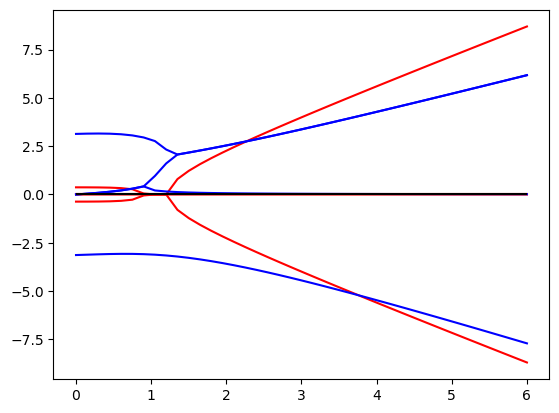

In [9]:
realPart,imagPart=SortEigenValues(output)
plt.plot(velocity,imagPart[:,0],'r')
plt.plot(velocity,imagPart[:,1],'r')
plt.plot(velocity,imagPart[:,2],'r')
plt.plot(velocity,imagPart[:,3],'r')
plt.plot(velocity,realPart[:,0],'b')
plt.plot(velocity,realPart[:,1],'b')
plt.plot(velocity,realPart[:,2],'b')
plt.plot(velocity,realPart[:,3],'b')
plt.hlines(0,xmin=0,xmax=6,colors='k')
# plt.ylim((-10,10))
# plt.ylim((-5,5))
plt.show()

tuning the feedback gain

In [38]:
# state = phi, delta, phidot, deltadot
# bike=Bike()
velocity=np.linspace(1,6,21)
# velocity=-np.linspace(2,7,21)
Krs=[]
xdphi=[]
xddelta=[]
for v in velocity:
    A,B=bike.LinearMatrix(v)
    C=np.array([[1,0,0,0],[0,1,0,0]])
    QW=np.diag([1,1,1,50])
    RW=10
    Kr, _, _ = ct.lqr(A,B,QW,RW)
    Krs.append(Kr.flatten().copy())
    eigValue=np.linalg.eig(A-B@Kr)[0]
    # print(np.real(eigValue))
    xd=-inv(A-B@Kr)@B
    xdphi.append(xd[0,0])
    xddelta.append(xd[1,0])
Krs=np.array(Krs)
# Krs

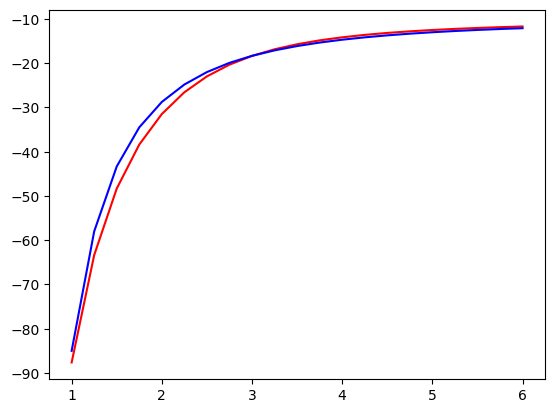

In [41]:
plt.plot(velocity,Krs[:,0],'r')
plt.plot(velocity,-75/velocity**2-10,'b')
plt.show()

In [42]:
# state = phi, delta, phidot, deltadot
g=9.81
eigs=[]
for v in velocity:
    A,B=bike.LinearMatrix(v)
    C=np.array([[1,0,0,0],[0,1,0,0]])
    # Kr=np.array([[65/(v+1.4)-7,3.2*(v+2.8)**2+36,20/(v+1.4)+1.7*v+2,0.06*(v+2.8)**2+3.3]]) # backward, lmd=0,c=0
    Kr=np.array([[-75/v**2-10,0.9*v**2+8,-27/v**2,0.065*v**2+3.6]]) # forward, lmd=0,c=0
    # Kr=np.array([[-170/v**2,13*np.exp(-0.3*(v-2.5)**2)+7,-60/v**2,2.1*np.exp(-0.15*(v-1.5)**2)+0.8]]) # forward, default
    eigs.append(np.linalg.eig(A-B@Kr)[0])
eigs=np.array(eigs)

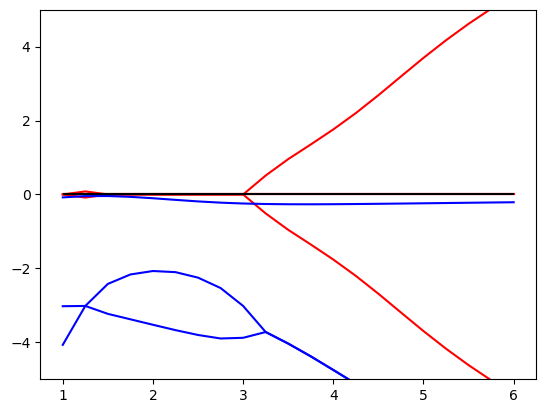

In [44]:
realPart,imagPart=SortEigenValues(eigs)
plt.plot(velocity,imagPart[:,0],'r')
plt.plot(velocity,imagPart[:,1],'r')
plt.plot(velocity,imagPart[:,2],'r')
plt.plot(velocity,imagPart[:,3],'r')
plt.plot(velocity,realPart[:,0],'b')
plt.plot(velocity,realPart[:,1],'b')
plt.plot(velocity,realPart[:,2],'b')
plt.plot(velocity,realPart[:,3],'b')
plt.hlines(0,xmin=1,xmax=6,colors='k')
# plt.hlines(0,xmin=-7,xmax=-2,colors='k')
# plt.ylim((-10,10))
plt.ylim((-5,5))
plt.show()

# Wheel

In [2]:
g=9.81
rR=0.3
m=2
Ixz=0.0603
Iy=0.12
btheta=0.01
bpsi=0.01
bphi=0.01
btheta=bpsi=bphi=0

theta0,psi0,phi0=0,0,15/180*pi
thetadot0,psidot0,phidot0=-2*pi/0.5,24.137/180*pi,0
interval=0.0001
timeLength=4
timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))
x=np.array([[theta0],[psi0],[phi0]])
xdot=np.array([[thetadot0],[psidot0],[phidot0]])
output=[]
output.append(np.vstack((x,xdot)))
energy=[]
theta,psi,phi=x.flatten()
thetadot,psidot,phidot=xdot.flatten()
KE=1/2*m*rR**2*(thetadot**2+sin(phi)**2*psidot**2+phidot**2+2*sin(phi)*thetadot*psidot)+1/2*Iy*(thetadot+psidot*sin(phi))**2+1/2*Ixz*(phidot**2+psidot**2*cos(phi)**2)
PE=m*g*rR*cos(phi)
energy.append(KE+PE)
for i in range(int(timeLength/interval)):
    theta,psi,phi=x.flatten()
    thetadot,psidot,phidot=xdot.flatten()
    M=np.array([
        [m*rR**2+Iy,m*rR**2*sin(phi)+Iy*sin(phi),0],
        [m*rR**2*sin(phi)+Iy*sin(phi),m*rR**2*sin(phi)**2+Iy*sin(phi)**2+Ixz*cos(phi)**2,0],
        [0,0,m*rR**2+Ixz]
    ])
    A=np.array([
        [(2*m*rR**2+Iy)*cos(phi)*psidot*phidot+btheta*thetadot],
        [(m*rR**2+Iy-Ixz)*sin(2*phi)*psidot*phidot+Iy*cos(phi)*thetadot*phidot+bpsi*psidot],
        [-(m*rR**2+Iy-Ixz)*sin(phi)*cos(phi)*psidot**2-(m*rR**2+Iy)*cos(phi)*thetadot*psidot-m*g*rR*sin(phi)+bphi*phidot],
    ])
    xdot2=-inv(M)@A
    x=x+xdot*interval
    xdot=xdot+xdot2*interval
    output.append(np.vstack((x,xdot)))
    KE=1/2*m*rR**2*(thetadot**2+sin(phi)**2*psidot**2+phidot**2+2*sin(phi)*thetadot*psidot)+1/2*Iy*(thetadot+psidot*sin(phi))**2+1/2*Ixz*(phidot**2+psidot**2*cos(phi)**2)
    PE=m*g*rR*cos(phi)
    energy.append(KE+PE)
output=np.array(output).reshape((-1,6))
theta,psi,phi,thetadot,psidot,phidot=output.T
energy=np.array(energy)

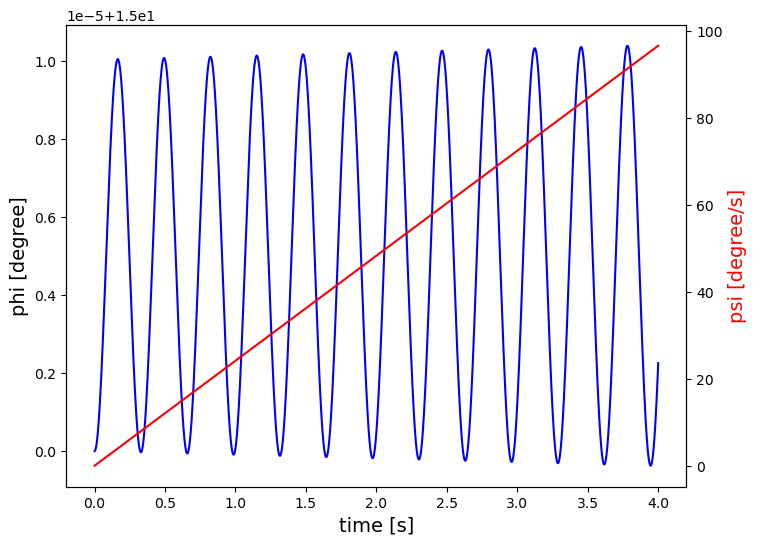

In [3]:
plt.figure(figsize=(8,6))
plt.plot(timeVector,phi*180/pi, 'b')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('phi [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,psi*180/pi, 'r')
rightax.set_ylabel('psi [degree/s]',fontsize=14)
# rightax.plot(timeVector,psidot*180/pi, 'r')
# rightax.set_ylabel('psidot [degree/s]',fontsize=14)
# rightax.plot(timeVector,energy, 'r')
# rightax.set_ylabel('energy [J]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

In [4]:
g=9.81
rR=r=0.3
m=2
Ixz=It=0.0603
Iy=Ia=0.12
btheta=0.01
bpsi=0.01
bphi=0.01
btheta=bpsi=bphi=0

interval=0.0001
timeLength=4
timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))
x=np.array([[-psi0],[phi0+pi/2],[theta0]])
xdot=np.array([[-psidot0],[phidot0],[thetadot0]])
psi,theta,phi=x.flatten()
output=[]
output.append(np.array([phi,-psi,theta-pi/2]))
energy=[]
psi,theta,phi=x.flatten()
psidot,thetadot,phidot=xdot.flatten()
KE=1/2*Iy*(psidot*cos(theta)+phidot)**2+1/2*Ixz*(psidot**2*sin(theta)**2+thetadot**2)+1/2*m*r**2*(phidot**2+thetadot**2+cos(theta)**2*psidot**2+2*cos(theta)*phidot*psidot)
PE=m*g*rR*sin(theta)
energy.append(KE+PE)
Ptheta=[]
Pphi=[]
Ptheta.append((It+m*r**2)*thetadot)
Pphi.append(Ia*(psidot*cos(theta)+phidot)+m*r**2*phidot+m*r**2*cos(theta)*psidot)
for i in range(int(timeLength/interval)):
    psi,theta,phi=x.flatten()
    psidot,thetadot,phidot=xdot.flatten()
    M=np.array([
        [(Ia+m*r**2)*cos(theta)**2+It*sin(theta)**2,0,(Ia+m*r**2)*cos(theta)],
        [0,It+m*r**2,0],
        [(Ia+m*r**2)*cos(theta),0,Ia+m*r**2]
    ])
    f=np.array([
        [(Ia-It+m*r**2)*2*sin(theta)*cos(theta)*psidot*thetadot+Ia*sin(theta)*thetadot*phidot],
        [-(Ia-It+m*r**2)*sin(theta)*cos(theta)*psidot**2-(Ia+m*r**2)*sin(theta)*psidot*phidot-m*g*r*cos(theta)],
        [(Ia+2*m*r**2)*sin(theta)*psidot*thetadot],
    ])
    xdot2=inv(M)@f
    x=x+xdot*interval
    xdot=xdot+xdot2*interval
    output.append(np.array([phi%(2*pi),-psi%(2*pi),(theta-pi/2)%(2*pi)]))
    KE=1/2*Iy*(psidot*cos(theta)+phidot)**2+1/2*Ixz*(psidot**2*sin(theta)**2+thetadot**2)+1/2*m*r**2*(phidot**2+thetadot**2+cos(theta)**2*psidot**2+2*cos(theta)*phidot*psidot)
    PE=m*g*rR*sin(theta)
    energy.append(KE+PE)
    Ptheta.append((It+m*r**2)*thetadot)
    Pphi.append(Ia*(psidot*cos(theta)+phidot)+m*r**2*phidot+m*r**2*cos(theta)*psidot)
output=np.array(output).reshape((-1,3))
theta,psi,phi=output.T
energy=np.array(energy)
Ptheta=np.array(Ptheta)
Pphi=np.array(Pphi)

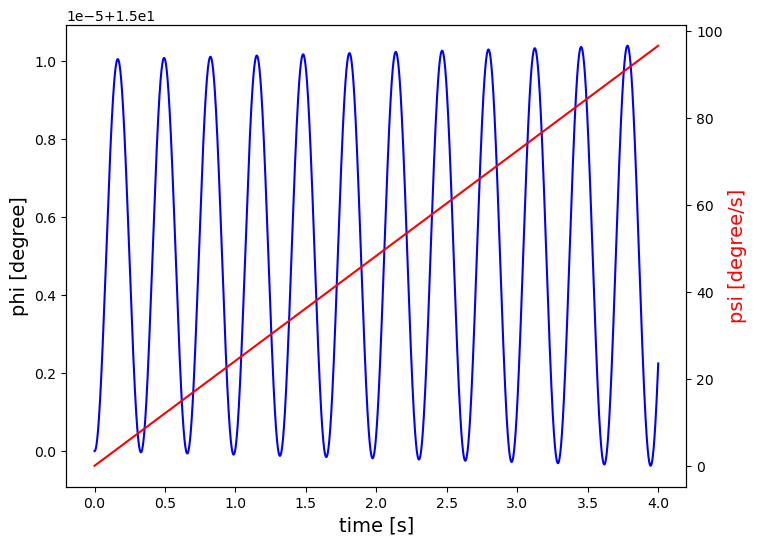

In [8]:
plt.figure(figsize=(8,6))
plt.plot(timeVector,phi*180/pi, 'b')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('phi [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,psi*180/pi, 'r')
rightax.set_ylabel('psi [degree/s]',fontsize=14)
# rightax.plot(timeVector,psidot*180/pi, 'r')
# rightax.set_ylabel('psidot [degree/s]',fontsize=14)
# rightax.plot(timeVector,energy, 'r')
# rightax.set_ylabel('energy [J]',fontsize=14)
# rightax.plot(timeVector,Ptheta, 'r')
# rightax.set_ylabel('Ptheta [J*s]',fontsize=14)
# rightax.plot(timeVector,Pphi, 'r')
# rightax.set_ylabel('Pphi [J*s]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()